In [1]:

# environment setup
import os
# one API particularly on Intel architectures Deep Neural Network Library (oneDNN)
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'

# NVIDIA's GPU-accelerated library for Deep Neural Network Library (cuDNN)
os.environ['TF_ENABLE_CUDNN_OPTS'] = '1'

# The output messages generated during the execution of DeepReg functions.(0..4)
os.environ['DEEPREG_LOG_LEVEL'] = '2' # WARNING: Indicates potential issues that are not necessarily errors.

# TensorFlow to control the logging level (0..4)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' # WARNING logs and above are shown (removes INFO and DEBUG logs).



import tensorflow as tf
from tensorflow.keras.layers import Input,Dense, GRU, LSTM, SimpleRNN, Flatten, Dropout,MaxPooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
import time



# Clears the default graph stack and resets the global default graph
tf.compat.v1.reset_default_graph()

# # for a in /sys/bus/pci/devices/*; do echo 0 | sudo tee -a $a/numa_node; done


# Return a list of physical devices visible to the host runtime.
gpus = tf.config.list_physical_devices('GPU')

if gpus:
    try:
        # Set memory growth for each GPU to true
        for gpu in gpus:           
            
            # Set if memory growth should be enabled for a PhysicalDevice
            tf.config.experimental.set_memory_growth(gpu, True)
            
            # print(str(gpu[0][-5:])) # cut out from the message 'gpu' only the GPU unit name (example GPU:0)
            # Resets the tracked memory stats for the chosen device.
            tf.config.experimental.reset_memory_stats(str(gpu[0][-5:]))
            # according to tensorflow documentation, it does not currently work for CPU
            
        # Return a list of logical devices created by runtime.   
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")

        # lists GPU devices and specifies whether virtual memory expansion is enabled
        for gpu in gpus:
            print(f"Device: {gpu}, Memory Growth: {tf.config.experimental.get_memory_growth(gpu)}")

    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

from tensorflow.keras import mixed_precision
# Set the Mixed Precision Policy You need to set the "mixed_float16" policy, which allows for computations in float16 and 
# maintains certain variables in float32, to ensure numerical stability.
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)


# Verify Policy Setup You can verify that the policy has been set correctly with the following command:
print()
print('Compute dtype:', policy.compute_dtype)
print('Variable dtype:', policy.variable_dtype)      

1 Physical GPUs, 1 Logical GPUs
Device: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), Memory Growth: True

Compute dtype: float16
Variable dtype: float32


In [2]:

# incarca seul de date
path = os.path.join("dataset/train_dataset")
train_dataset = tf.data.Dataset.load(path)

path = os.path.join("dataset/val_dataset")
val_dataset = tf.data.Dataset.load(path)

names_class = pd.read_csv('dataset/list_label_name.csv')
names_class = names_class[names_class.columns[1]].values.tolist()

print('names_class : ', names_class)



names_class :  ['Drink', 'Picking', 'Push', 'Run', 'Throwing objects', 'boxing', 'lifting weights', 'receiving the phone', 'stand', 'walking on stairs', 'walking with flashlight', 'waving']


In [3]:
# expand val_dataset to see the tensor dimensions
def test_dataset(dataset):
   
    feauter = [0]
    labels = [0]

    # iterates the tensor composed of features and labels (x,y)
    for x, y in dataset:
        
        # count how many packages there are (first digit)
        feauter[0] += 1
        labels[0] += 1

        # add matrix format
        if feauter[0] < 2:
            for xx in x.numpy().shape:
                feauter.append(xx)
            for yy in y.numpy().shape:
                labels.append(yy)
    
    return feauter, labels

# call the test_dataset function
train_feauter_dim, train_labels_dim = test_dataset(train_dataset)
val_feauter_dim, val_labels_dim = test_dataset(val_dataset)

print(train_feauter_dim)
print(train_labels_dim)
print(val_feauter_dim)
print(val_labels_dim)

[5290, 10, 240, 320, 3]
[5290, 12]
[1323, 10, 240, 320, 3]
[1323, 12]


In [4]:
# normalize and create batches
batch_size = 64

def normalization(x, y): 
    x = tf.cast(x, tf.float16) / 255.0
    y = tf.cast(y, tf.float16) 
    return x, y 



# Normally, test datasets are data that do not participate in any way in training, 
# in this case we approached this trick because the database used is small
test_dataset = val_dataset.map(normalization).batch(1)

# we use the .map() method from tf.data.Dataset to transform the elements 
train_dataset = train_dataset.map(normalization).batch(batch_size) 
val_dataset = val_dataset.map(normalization).batch(batch_size)



In [5]:
# Configuring the dataset for better performance

# - prefetch(): Este un API care realizeaza preancarcarea datelor (s+1) in timp ce modelul proceseaza datele anterioare (s)
#               Parametrizarea poate fi facuta manual sau automata tf.data.AUTOTUNE (prefetch(buffer_size=AUTOTUNE))
#               In cazul setari manual a cestui API, buffer_size trebuie sa fie mai mare sau egal cu numarul de loturi consumate intr-o epoca

# - cache(): Păstrează datele în memorie după ce au fost încărcate de pe disc în o anumita perioade de timp.
#            Acest lucru va salva unele operațiuni (cum ar fi deschiderea fișierelor și citirea datelor) de la executarea în fiecare epocă.

# .shuffle(100) - coeficient de amestecare


AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.cache().prefetch(buffer_size=AUTOTUNE).shuffle(1234)
val_dataset = val_dataset.cache().prefetch(buffer_size=AUTOTUNE)

In [6]:

# defines the number of outputs, i.e. the number of hidden neurons RNN
out_units_1 = 128
out_units_2 = 64
out_units_3 = 32

# defines the entry (10, 240, 320, 3)
inputs = Input(shape = (train_feauter_dim[1], train_feauter_dim[2], train_feauter_dim[3], train_feauter_dim[4]))

# layer 1 of the CNN network
conv_L = tf.keras.layers.TimeDistributed(tf.keras.layers.Conv2D(256, (15, 15), strides=(15, 15), padding="same", activation="relu", use_bias=True))(inputs)
conv_L = tf.keras.layers.TimeDistributed(MaxPooling2D(pool_size=(2, 2),strides=(2, 2), padding="same"))(conv_L)
conv_L = tf.keras.layers.TimeDistributed(Dropout(0.5))(conv_L)


# Trasforma matricele rezultate din layer 4 in vectori
flat = tf.keras.layers.TimeDistributed(Flatten())(conv_L)

# layer 1 of the RNN network
SimpleRNN_L1 = SimpleRNN(units = out_units_1, return_sequences=True, return_state=False, activation='tanh', use_bias=True)(flat) 
SimpleRNN_L1 = Dropout(0.5)(SimpleRNN_L1)

# layer 2 of the RNN network
SimpleRNN_L2 = SimpleRNN(units = out_units_2, return_sequences=True, return_state=False, activation='tanh', use_bias=True)(SimpleRNN_L1)
SimpleRNN_L2 = Dropout(0.5)(SimpleRNN_L2)

# layer 3 of the RNN network
SimpleRNN_L3 = SimpleRNN(units = out_units_3, return_sequences=False, return_state=False, activation='tanh', use_bias=True)(SimpleRNN_L2)
SimpleRNN_L3 = Dropout(0.5)(SimpleRNN_L3)

# return_state=False - disables the transmission of hidden states to another network
# return_sequences=True - transmits all the results of the iterations in the RNN network
# return_sequences=False - transmits only the last iteration result from the RNN network

# Layer 4 is a simple Dense network
out = Dense(train_labels_dim[1], activation='softmax')(SimpleRNN_L3)

# create the network model
CNN_SimpleRNN_model = Model(inputs=inputs, outputs =out)

In [7]:
# print the model's characteristics table
CNN_SimpleRNN_model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 10, 240, 320,   │             0 │
│                                 │ 3)                     │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cast (Cast)                     │ (None, 10, 240, 320,   │             0 │
│                                 │ 3)                     │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 10, 16, 22,     │       173,056 │
│ (TimeDistributed)               │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 10, 8, 11, 256) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_2              │ (None, 10, 8, 11, 256) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_3              │ (None, 10, 22528)      │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn (SimpleRNN)          │ (None, 10, 128)        │     2,900,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_1 (SimpleRNN)        │ (None, 10, 64)         │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_2 (SimpleRNN)        │ (None, 32)             │         3,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 12)             │           396 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,089,004 (11.78 MB)

 Trainable params: 3,089,004 (11.78 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
# defines the loss function
def loss_value(y_true, y_pred):

    ## loss = mean(square(log(y_true + 1) - log(y_pred + 1)), axis=-1)
    loss = tf.keras.losses.MSLE(y_true, y_pred)

    ## loss = mean(square(y_true - y_pred), axis=-1)
    #loss = tf.keras.losses.MSE(y_true, y_pred)
  
    return loss

In [9]:
# defines the function of measuring the quality of the results obtained
def metric(y_true, y_pred):

    metric_acu = tf.keras.metrics.CategoricalAccuracy()
    metric = metric_acu(y_true, y_pred)

    return metric.numpy() 

In [10]:

# defines the optimization function
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

# creates the weight correction implementation step 
def train_step(x, y):

    #Record operations for automatic differentiation.
    with tf.GradientTape() as tape:
        # launches the model 
        prediction = CNN_SimpleRNN_model(x, training=True)
        # via the loss function, returns the entropy value
        current_loss = loss_value( y, prediction)

    # extract gradients from the model
    grads = tape.gradient( current_loss , CNN_SimpleRNN_model.trainable_weights)
    # correction gradients are applied through the tf.keras.optimizers class
    optimizer.apply_gradients( zip( grads , CNN_SimpleRNN_model.trainable_weights))
    
    return current_loss
        

In [11]:

# defines the number of epochs
epochs = 50

# defines the list of loss values
train_loss_values=[]
val_loss_values=[]

# defines the list of accuracy values
train_metric_values=[]
val_metric_values=[]

# defines the loop function for learning
for i in range(epochs):

    # print epoch / total epoch
    print("epoch: ", str(i+1), f"/ {str(epochs)}" )

    # defines the list of packet loss values for the current epoch
    train_batch_loss = []
    # defineste lista volorilor de acuratete a pachetelor din epoca curenta
    train_batch_metric = []

    # defineste obiectul barei de propagare
    progbar_train = tf.keras.utils.Progbar(len(train_dataset)-1, unit_name = 'Training')
    
    for step_train, (x_train_batch, y_train_batch) in enumerate(train_dataset):

        # propagation step increment
        progbar_train.update(step_train)

        # launches 'train_step' with input values 'x_train_batch' and their associated labels 'y_train_batch'
        train_current_loss = train_step(x_train_batch, y_train_batch)
        # add the entropy value to the list
        train_batch_loss.append(np.mean(train_current_loss))

        # launch the model execution with the input values 'x_train_batch' to obtain the model prediction at that moment with the option 
        # 'training=False' i.e. stop/modify the functions: Dropout, Normalize ...etc
        train_predict = CNN_SimpleRNN_model(x_train_batch,training=False)

        # get the accuracy value (y_train_batch vs train_predict)
        train_current_metric = metric(y_train_batch, train_predict)
        train_batch_metric.append(np.mean(train_current_metric))

    # add the arithmetic means of the values to the final list for each epoch
    train_loss_values.append(np.mean(train_batch_loss))
    train_metric_values.append(np.mean(train_batch_metric))

    # intermediate display of values
    print("loss train_set", str(np.mean(train_batch_loss)))
    print("metric train", str(np.mean(train_batch_metric)))


      
                    # In the case of model releases with validation data, the description is similar to the above mentions.
    val_batch_loss = []
    val_batch_metric = []
    
    progbar_val = tf.keras.utils.Progbar(len(val_dataset)-1, unit_name = 'Validation') 
    for step_val, (x_val_batch, y_val_batch) in enumerate(val_dataset):

        progbar_val.update(step_val)
        
        val_predict = CNN_SimpleRNN_model(x_val_batch,training=False)
        
        val_current_loss = loss_value(y_val_batch,val_predict)
        val_batch_loss.append(np.mean(val_current_loss))

        val_current_metric = metric(y_val_batch, val_predict)
        val_batch_metric.append(np.mean(val_current_metric))
        
    val_loss_values.append(np.mean(val_batch_loss))
    val_metric_values.append(np.mean(val_batch_metric))
        
    print("loss val_set", str(np.mean(val_batch_loss)))
    print("metric val", str(np.mean(val_batch_metric)))
    print()




epoch:  1 / 50
82/82 ━━━━━━━━━━━━━━━━━━━━ 37s 190ms/Training
loss train_set 0.04073977
metric train 0.14723177
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 80ms/Validation
loss val_set 0.03625165
metric val 0.20937154

epoch:  2 / 50
82/82 ━━━━━━━━━━━━━━━━━━━━ 15s 187ms/Training
loss train_set 0.0378167
metric train 0.24900496
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/Validation
loss val_set 0.035733715
metric val 0.2610569

epoch:  3 / 50
82/82 ━━━━━━━━━━━━━━━━━━━━ 15s 188ms/Training
loss train_set 0.036325816
metric train 0.31095812
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/Validation
loss val_set 0.033249926
metric val 0.34250417

epoch:  4 / 50
82/82 ━━━━━━━━━━━━━━━━━━━━ 15s 187ms/Training
loss train_set 0.034961745
metric train 0.3678195
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/Validation
loss val_set 0.030998196
metric val 0.36370087

epoch:  5 / 50
82/82 ━━━━━━━━━━━━━━━━━━━━ 15s 188ms/Training
loss train_set 0.033364765
metric train 0.41205895
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/Validation
loss val_set 0.028978337

In [12]:
# similar result to the Model.evaluate() method
# in this case, we take the average of the results from the last epoch 
print()
print('Validation dataset')
print('loss values : ', val_loss_values[-1])
print('metric values : ', val_metric_values[-1])


Validation dataset
loss values :  0.013069926
metric values :  0.7653654


In [13]:
# save, create directory
if not os.path.isdir('rezult_CNN_SimpleRNN_model'):
    os.makedirs('rezult_CNN_SimpleRNN_model')

# save training graphs
np.save('rezult_CNN_SimpleRNN_model/CNN_SimpleRNN_model_train_loss.npy', train_loss_values)
np.save('rezult_CNN_SimpleRNN_model/CNN_SimpleRNN_model_val_loss.npy', val_loss_values)
np.save('rezult_CNN_SimpleRNN_model/CNN_SimpleRNN_model_train_metric.npy', train_metric_values)
np.save('rezult_CNN_SimpleRNN_model/CNN_SimpleRNN_model_val_metric.npy', val_metric_values)


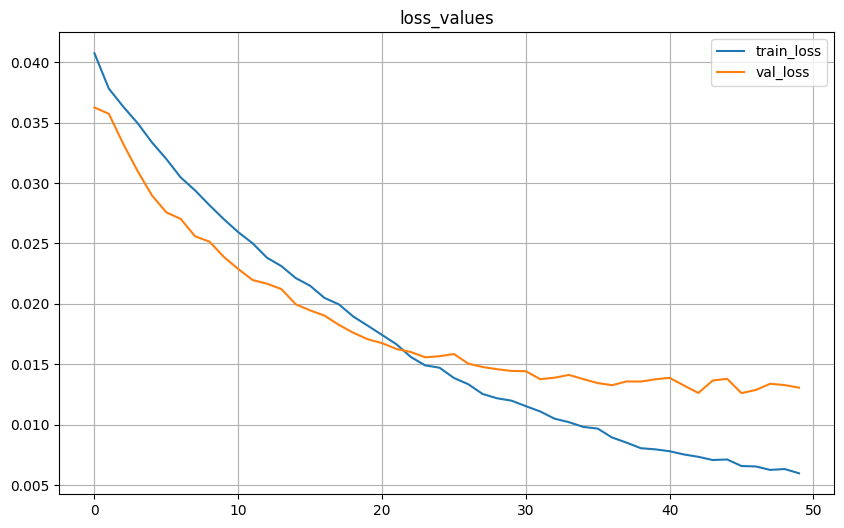

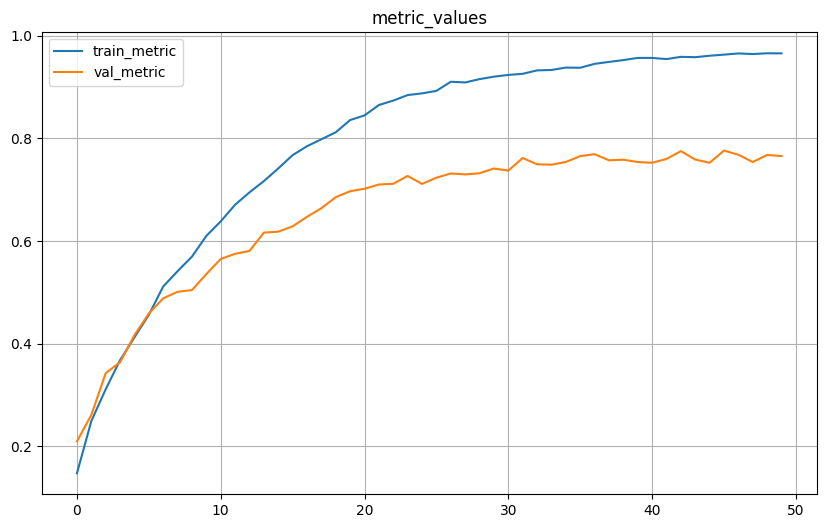

In [14]:
# plot the graph of entropy change versus the number of epochs
plt.figure(figsize=(10,6)) 
plt.plot(train_loss_values, label = 'train_loss')
plt.plot(val_loss_values, label = 'val_loss')
plt.legend() 
plt.title('loss_values')
plt.grid()
plt.show()
print()
# plot the graph of change in accuracy versus number of epochs
plt.figure(figsize=(10,6)) 
plt.plot(train_metric_values, label = 'train_metric')
plt.plot(val_metric_values, label = 'val_metric')
plt.legend() 
plt.title('metric_values')
plt.grid()
plt.show()


In [15]:
# generates validation/testing results
test_labels = []
test_pred = []

progbar_test = tf.keras.utils.Progbar(len(test_dataset)-1, unit_name = 'Test')
for step_test, (x_test, y_test) in enumerate(test_dataset):

    progbar_test.update(step_test)

    test_labels.append(y_test[0])

    y = CNN_SimpleRNN_model(x_test, training=False)
    test_pred.append(y[0])

test_labels = np.array(test_labels)
test_pred = np.array(test_pred)


1322/1322 ━━━━━━━━━━━━━━━━━━━━ 65s 49ms/Test


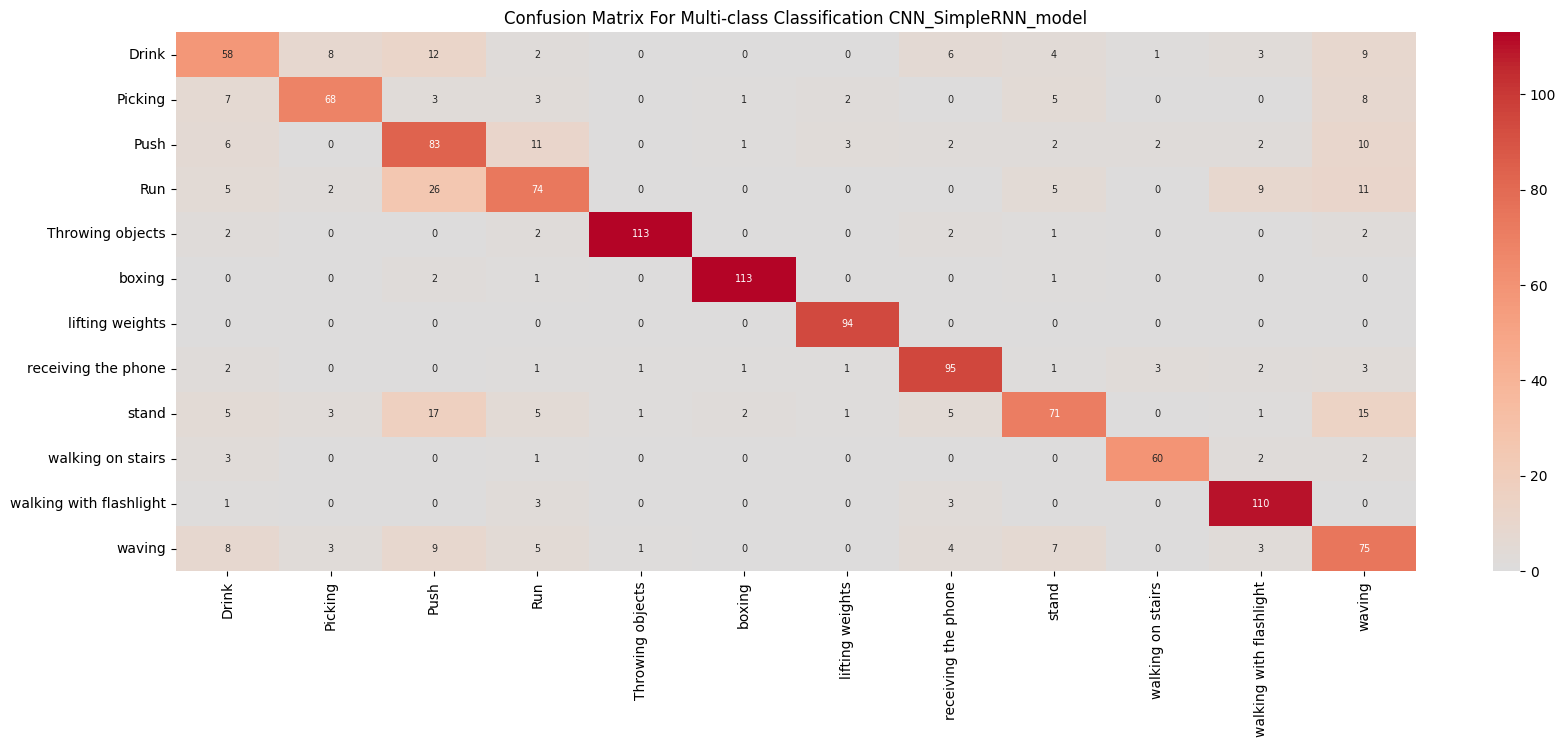

In [16]:
# creaza matricea de confuzie


# indicates the position of the maximum value on, resulting from SoftMax 
label = tf.argmax(test_labels, axis = 1)
pred = tf.argmax(test_pred, axis = 1)

# create the confusion matrix
cm = tf.math.confusion_matrix(label, pred)

# create data frame
cm_df = pd.DataFrame(cm, index = names_class, columns = names_class)

print()
# plot data frame
plt.figure(figsize=(20, 7))
plt.title('Confusion Matrix For Multi-class Classification CNN_SimpleRNN_model')
sns.heatmap(cm_df, annot=True, cmap='coolwarm', center=0, annot_kws={'size': 'x-small'}, fmt='d')
plt.savefig('rezult_CNN_SimpleRNN_model/CNN_SimpleRNN_model_matrix_conf.png')
plt.show()

In [17]:
#save model
tf.keras.models.save_model(model = CNN_SimpleRNN_model, filepath='rezult_CNN_SimpleRNN_model/CNN_SimpleRNN_model.keras', overwrite=True)

In [18]:
# create the model schema
# tf.keras.utils.plot_model(CNN_SimpleRNN_model, to_file='rezult_CNN_SimpleRNN_model/CNN_SimpleRNN_model.png', show_dtype=True,
#                           show_shapes=True, show_layer_names=False, rankdir='TB', expand_nested=False, 
#                           show_layer_activations=True, show_trainable=True)